<a href="https://colab.research.google.com/github/ddiaz1999/Face_Mask_Detection_System/blob/master/3_class_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
DIRECTORY  = '/content/drive/My Drive/Face Mask Detection/dataset'
CATEGORIES  = ['mask_weared_incorrect','with_mask','without_mask']

In [5]:
print("[INFO] loading images...")

data = []
labels = []

contador = 0
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

print(np.array(data).shape)
print(labels)
print(np.array(labels).shape)

[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(5829, 224, 224, 3)
['mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mask_weared_incorrect', 'mas

In [6]:
values = np.array(labels)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

print(labels)
data = np.array(data, dtype="float32")
labels = np.array(labels)


(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [7]:
print(trainX.shape)

(4663, 224, 224, 3)


[INFO] compiling model...
[INFO] training head...
Epoch 1/12
145/145 [==============================] - 52s 357ms/step - loss: 0.2875 - accuracy: 0.8154 - val_loss: 0.1083 - val_accuracy: 0.9520
Epoch 2/12
145/145 [==============================] - 51s 351ms/step - loss: 0.1085 - accuracy: 0.9413 - val_loss: 0.0679 - val_accuracy: 0.9631
Epoch 3/12
145/145 [==============================] - 51s 353ms/step - loss: 0.0860 - accuracy: 0.9557 - val_loss: 0.0607 - val_accuracy: 0.9691
Epoch 4/12
145/145 [==============================] - 51s 352ms/step - loss: 0.0658 - accuracy: 0.9687 - val_loss: 0.0541 - val_accuracy: 0.9708
Epoch 5/12
145/145 [==============================] - 51s 350ms/step - loss: 0.0532 - accuracy: 0.9741 - val_loss: 0.0531 - val_accuracy: 0.9717
Epoch 6/12
145/145 [==============================] - 51s 352ms/step - loss: 0.0543 - accuracy: 0.9719 - val_loss: 0.0450 - val_accuracy: 0.9734
Epoch 7/12
145/145 [==============================] - 51s 351ms/step - loss: 0.0

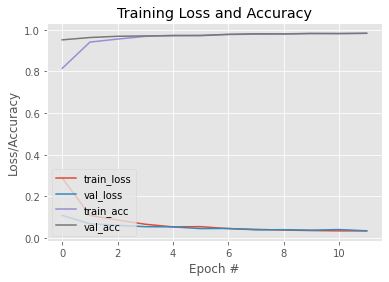

In [8]:
INIT_LR = 1e-4
EPOCHS = 12
BS = 32

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")

with tf.device('/device:GPU:0'):
  H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=CATEGORIES))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")